# Emotion detection

In [8]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D  
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau  
from tensorflow.keras.utils import plot_model  
from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)




Tensorflow version: 2.10.0


**Exploring Dataset**

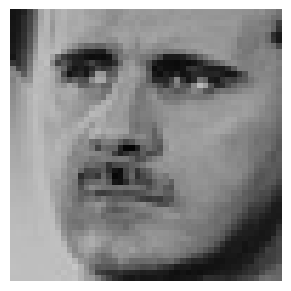

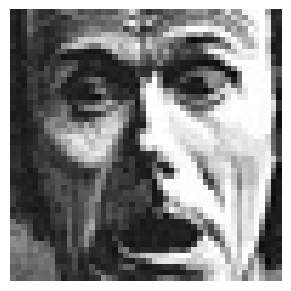

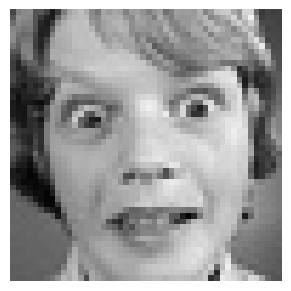

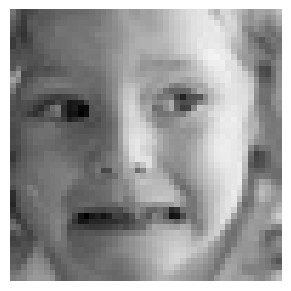

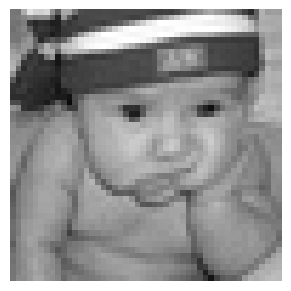

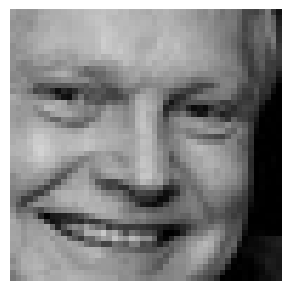

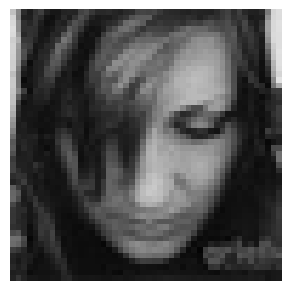

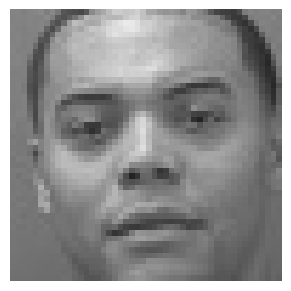

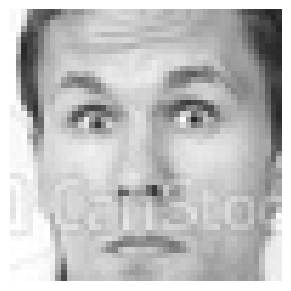

In [10]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

In [11]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x


In [13]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [14]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))

    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten,256)

    output  = Dense(7, activation="softmax")(dense_1)
    model  =  Model(inputs=[inputs],outputs = [output])
    
    model.compile(loss=['categorical_crossentropy'] , optimizer = 'adam' , metrics =["accuracy"])

    return model

In [15]:
model = model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_3 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 32)        0     

In [16]:

epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
callbacks = [checkpoint]

In [17]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)


Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 1.6896 - accuracy: 0.3530
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 508s 1s/step - loss: 1.6896 - accuracy: 0.3530 - val_loss: 1.6713 - val_accuracy: 0.3673
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.4037 - accuracy: 0.4651
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 70s 155ms/step - loss: 1.4037 - accuracy: 0.4651 - val_loss: 1.5058 - val_accuracy: 0.4463
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.2835 - accuracy: 0.5106
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 66s 147ms/step - loss: 1.2835 - accuracy: 0.5106 - val_loss: 1.3958 - val_accuracy: 0.4611
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.2089 - accuracy: 0.5424
Epoch 4: saving model to model_weights.h5
448/448 [==============================] - 64s 1

In [18]:
model.evaluate(validation_generator)

113/113 [==============================] - 6s 55ms/step - loss: 1.1048 - accuracy: 0.6043


[1.104788899421692, 0.6043466329574585]

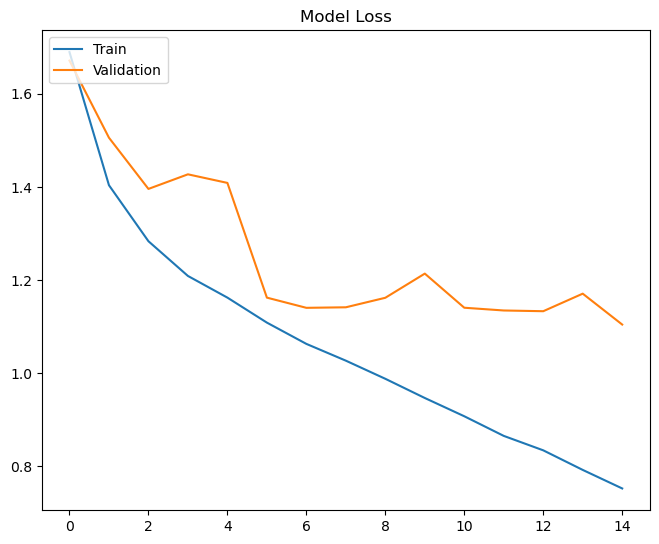

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

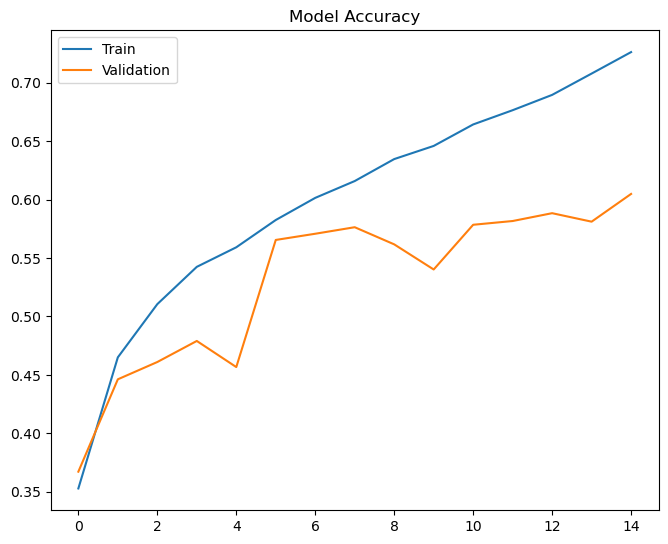

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

In [21]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)